In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
matplotlib.rcParams['figure.dpi'] = 65

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

Loading the dataframes exported in the previous part...

In [2]:
df = pd.read_pickle('./dataset/part2_matches.pkl')
players = pd.read_pickle('./dataset/part2_players.pkl')
tourneys_sex_df = pd.read_pickle('./dataset/part2_tourneys_sex.pkl')
tourneys_df = pd.read_pickle('./dataset/part2_tourneys.pkl')

- `df` is the dataframe containing the matches and the players' statistics
- `players` is the dataframe containing the players' general info (index: `fullname`)
- `tourneys_df` is the dataframe with the tournaments' info (index: `tourney_id`)
- `tourneys_sex_df` is the dataframe with the tournaments' info that depend on the specific gender(index: $\langle$`tourney_id`, `sex`$\rangle$)

---

# Data Understanding and Data Preparation (Part III)

## Dealing with Outliers

It's time to manage the outliers of the dataset.

Since the majority of the possible outliers has been already managed before (for example the age of the players when we computed the `birthday` field, and so on..) what remains to be managed concerns only the *heights* of the players and the *match statistics*.

### Players' Heights Outliers

We plot the distributions of the players' heights both with a boxplot and an histogram (using the Sturges formula as the number of bins) and we try to figure out which are the outliers.

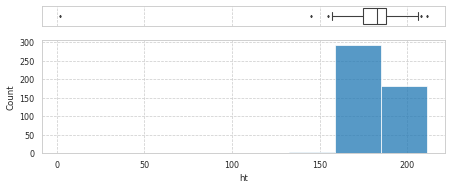

In [3]:
q1 = players.ht.quantile(0.25)
q3 = players.ht.quantile(0.75)
iqr = q3-q1

smallest = players.loc[players.ht > (q1 - 1.5 * iqr), "ht"].sort_values().iloc[0]
largest = players.loc[players.ht < (q3 + 1.5 * iqr), "ht"].sort_values(ascending=False).iloc[0]

htInWhiskers = players.loc[(players.ht >= smallest) & (players.ht <= largest), "ht"]
htInWhiskers.describe()

def sturgesBins(n):
    return math.ceil(math.log(n) + 1)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 3))
 
sns.boxplot(data=players, x="ht", fliersize=2, boxprops={'facecolor':'None'}, ax=ax_box)
sns.histplot(data=players.ht, bins=sturgesBins(htInWhiskers.size), ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()

As we can see, the presence of outliers can be visualized intuitively. Thus, we print the players whose heights are considered as outliers by coming out the whisker.

In [4]:
players[~(players.index.isin(htInWhiskers.index)) & ~(players.ht.isna())]

,hand,ioc,ht,sex,match_count,birthday
fullname,,,,,,
ivo karlovic,r,cro,208,m,205,1979-03-09
reilly opelka,r,usa,211,m,249,1997-09-02
kurumi nara,r,jpn,155,f,278,1992-01-05
kamilla rakhimova,r,rus,2,f,157,2001-09-01
ilija vucic,r,srb,145,m,20,1990-11-02


Following a brief web search, we found that:
* Ivo Karlovic, Reilly Opelka and Karumi Nara have the right height
* Ilika Vucic has the wrong height
* We can't find information about the height of Kamilla Rakhimova

In [5]:
players.loc['kamilla rakhimova', 'ht'] = np.nan
players.loc['ilija vucic', 'ht'] = 188

### Matches' Stats Outliers

Now it remains to manage the outliers of the matches' stats. When in the Part 2 of the notebook we plotted the scatter matrixes of some stats it was immediately clear the presence of outliers, for example we can examine in detail the behavior of the feature `w_1stWon` which indicates *the number of points won on the first serve*.

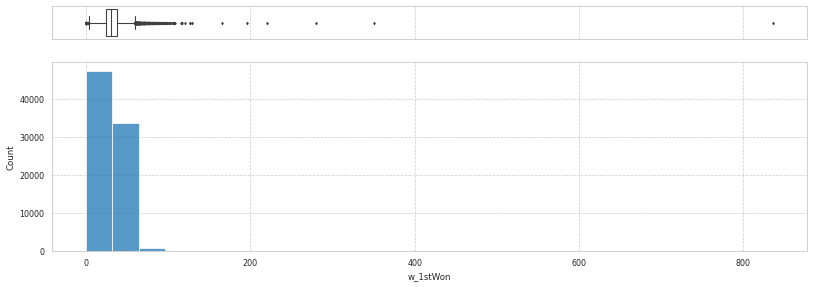

In [6]:
q1 = df.w_1stWon.quantile(0.25)
q3 = df.w_1stWon.quantile(0.75)
iqr = q3-q1

smallest = df.loc[df.w_1stWon > (q1 - 1.5 * iqr), "w_1stWon"].sort_values().iloc[0]
largest = df.loc[df.w_1stWon < (q3 + 1.5 * iqr), "w_1stWon"].sort_values(ascending=False).iloc[0]

inWhiskers = df.loc[(df.w_1stWon >= smallest) & (df.w_1stWon <= largest), "w_1stWon"]
inWhiskers.describe()

def sturgesBins(n):
    return math.ceil(math.log(n) + 1)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 5))
 
sns.boxplot(data=df, x="w_1stWon", fliersize=2, boxprops={'facecolor':'None'}, ax=ax_box)
sns.histplot(data=df.w_1stWon, bins=sturgesBins(inWhiskers.size)*2, ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [7]:
stats_columns = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

The presence of outliers is now more obvious, but don't know if those outliers are valid values or represents errors in the dataset. By making a simple count, in a *3 sets match* a player serves, with a large bound, *eight first serves per game*, which means for six games per set, *at most 144* first serves (which is an incredibly high upper bound, if we consider that we are looking for the *points on the first serve* at that five points makes a game unless for the presence of advantages). In fact, if we plot the *3 set* matches with more than 100 first serves won we obtain:

In [8]:
outliers_rows = []

t = df[((df.w_1stWon > 100) | (df.l_1stWon > 100)) & (df.best_of == 3)]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(t[['score'] + stats_columns])

,score,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
99364,1-6 7-6(6) 6-0,19,114,1957,1330,836,304,12,209,266,19,114,1672,893,532,399,13,114,190
99384,7-5 6-4,30,20,600,320,220,160,11,40,70,20,40,810,420,250,200,11,120,170
99567,6-4 7-6(6),72,72,640,384,280,112,11,16,24,40,0,624,504,320,56,11,32,48
99631,3-6 7-5 7-6(3),4,28,400,276,196,48,16,16,36,16,28,464,320,204,68,17,40,60
99994,5-7 7-5 6-1,0,45,918,702,351,90,15,108,180,0,36,972,774,369,45,16,81,180


Which are <u>totally senseless values</u>.

In [9]:
outliers_rows.append(t)

So, the approach we want to take is to *exclude values which just can't be happened*. 

Since we can't say anything about the matches with *5 sets* (but we've verified before that they only belong to the *Big Four* slams, the Olympics and the Davis Cup) since they don't allow the *tie-break* on the last set, so the last two games could possibly last forever (the longest match that ever took place is the famous *Isner - Mahut* at *Wimbledon 2010* which ended the last game in *70-68* for *John Isner*)!

In a *best of 3 match*, we can have <u>at most</u> (with high probability):
* 144 *first serves* (as explained above)
* 288 *total serves* (first and second serve)
* 105 *winning serves* or *double faults* (5 winning serves *per game* in 18 serving games)
* 78 *break points* (assuming an overestimation of 2 break points per game in a *7-6 6-7 7-6* match)

Furthermore, we have to remember that *the player with the highest number of aces in a match* is John Isner with *113 aces*, in the famous match mentioned above.

Now that we know all of this, we can remove some false statistics.

In [10]:
outliers_rows.append(df[((df.w_svpt > 288) | (df.l_svpt > 288)) & (df.best_of == 3)])
outliers_rows.append(df[((df.w_df > 105) | (df.l_df > 105)) & (df.best_of == 3)])
outliers_rows.append(df[((df.w_2ndWon > 105) | (df.l_2ndWon > 105)) & (df.best_of == 3)])
outliers_rows.append(df[((df.w_bpFaced > 78) | (df.l_bpFaced > 78)) & (df.best_of == 3)])

outliers_rows.append(df[(df.w_ace > 113) | (df.l_ace > 113)])

In [11]:
outliers = pd.concat(outliers_rows).drop_duplicates()
df.loc[outliers.index, stats_columns] = np.nan

At the same way, it's impossible that a player has won a match *without scoring any points*, <u>unless the match its won by flat rate</u>. Thus, we remove those in the same way since we don't want them to falsify the future features.

In [12]:
df.loc[df.w_svpt == 0, 'w_svpt'] = np.nan
df.loc[df.l_svpt == 0, 'l_svpt'] = np.nan
df.loc[df.w_SvGms == 0, 'w_SvGms'] = np.nan
df.loc[df.l_SvGms == 0, 'l_SvGms'] = np.nan

In [13]:
"""pd.plotting.scatter_matrix(
    df[stats_columns],
    alpha=0.4,
    figsize=(10, 10))
pass"""

'pd.plotting.scatter_matrix(\n    df[stats_columns],\n    alpha=0.4,\n    figsize=(10, 10))\npass'

In [14]:
#sns.pairplot(df[stats_columns], corner=True, dropna=True, height=2)

In [15]:
corr = df.drop(columns=['match_num', 'winner_rank_points', 'loser_rank_points']).corr()

<AxesSubplot:>

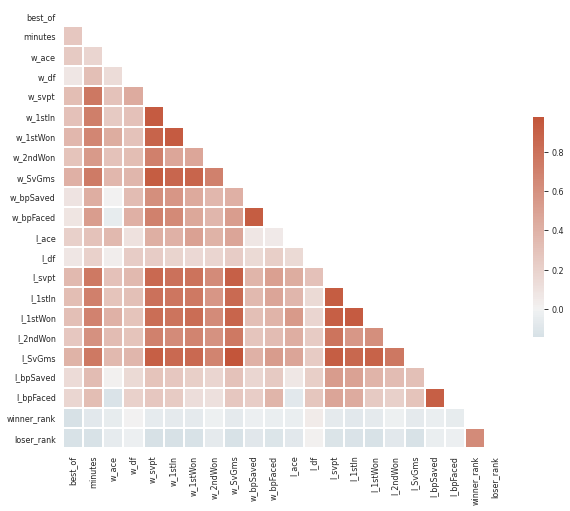

In [16]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Filling NaNs

The following step consists in managing the *null* values of the dataset. Obviously we are not interested in filling the dataset of the matches but rather we are interested in filling the players' and tournaments' dataset missing information, since we are going to use them in the next tasks. Moreover, we are *highly* interested in <u>preserving the current distributions</u> when filling the null values. 

In [17]:
tourneys_sex_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4933 entries, ('2019-m020', 'm') to ('2020-w-itf-usa-48a-2020', 'f')
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   draw_size      4933 non-null   Int64 
 1   tourney_level  4933 non-null   string
dtypes: Int64(1), string(1)
memory usage: 263.5+ KB


Luckily, one of three dataframe doesn't need it.

#### Surface

Let's start with the missing values in the `tourneys_df` dataset.

In [18]:
tourneys_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4853 entries, 2019-m020 to 2020-w-itf-usa-48a-2020
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_name        4853 non-null   string        
 1   surface             4791 non-null   string        
 2   tourney_date        4853 non-null   datetime64[ns]
 3   tourney_spectators  4853 non-null   Int64         
 4   tourney_revenue     4853 non-null   Float64       
dtypes: Float64(1), Int64(1), datetime64[ns](1), string(2)
memory usage: 237.0+ KB


The only feature that needs to be filled is the *surface*. We plot its distribution.

<AxesSubplot:>

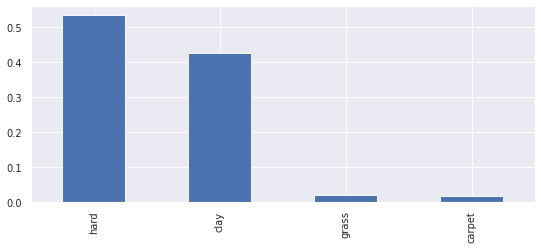

In [19]:
sns.set(rc={'figure.figsize':(10,4)})
tourneys_df['surface'].value_counts(normalize=True).plot(kind='bar')

Let's see which are the tournaments where the surface is missing.

In [20]:
t = tourneys_df[tourneys_df['surface'].isna()]
display(t['tourney_name'])

tourney_id
2017-w-fc-2017-g2-am-a-m-ecu-cub-01      fed cup g2 rr: ecu vs cub
2017-w-fc-2017-g2-am-a-m-ecu-uru-01      fed cup g2 rr: ecu vs uru
2017-w-fc-2017-g2-am-a-m-uru-cub-01      fed cup g2 rr: uru vs cub
2017-w-fc-2017-g2-am-b-m-dom-bar-01      fed cup g2 rr: dom vs bar
2017-w-fc-2017-g2-am-b-m-gua-bar-01      fed cup g2 rr: gua vs bar
                                                  ...             
2017-m-dc-2017-g2-epa-m-mon-slo-01     davis cup g2 r1: mon vs slo
2017-m-dc-2017-g2-epa-m-nor-lat-01     davis cup g2 r1: nor vs lat
2017-m-dc-2017-g2-epa-m-tur-cyp-01     davis cup g2 r1: tur vs cyp
2017-m-dc-2017-g2-ao-m-vie-hkg-01      davis cup g2 r1: vie vs hkg
2017-m-dc-2017-g1-ao-m-tpe-chn-01      davis cup g1 r1: tpe vs chn
Name: tourney_name, Length: 62, dtype: string

It seems that a lot of these matches are played in the *Davis Cup* or the *Fed Cup* (Billie Jean King Cup), are all the matches where the surface is null played in these two tournaments?

In [21]:
t[~(t['tourney_name'].str.contains('davis') | t['tourney_name'].str.contains('fed'))]

,tourney_name,surface,tourney_date,tourney_spectators,tourney_revenue
tourney_id,,,,,


All the rows with invalid surface are matches of the Davis Cup or Fed Cup, which are tournaments where each match is played on a different surface, except for the carpet. So we will drop it from the distribution.

In [22]:
surface_dist = tourneys_df['surface'][tourneys_df['surface'] != 'Carpet'].value_counts(normalize=True)
surface_dist

hard      0.533918
clay      0.426216
grass     0.021499
carpet    0.018368
Name: surface, dtype: Float64

And we just fill the null entries *according to the distribution* above.

In [23]:
miss = tourneys_df['surface'].isna()
tourneys_df.loc[miss, 'surface'] = np.random.choice(surface_dist.index, size=len(tourneys_df[miss]), p=surface_dist.values)

We plot again the distribution.

<AxesSubplot:>

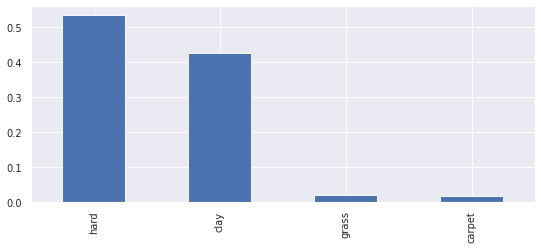

In [24]:
sns.set(rc={'figure.figsize':(10,4)})
tourneys_df['surface'].value_counts(normalize=True).plot(kind='bar')

Which respects the previous one!

#### Height - Hand - Nationality

In [25]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5027 entries, kei nishikori to kai lin zhang
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hand         2477 non-null   string
 1   ioc          5023 non-null   string
 2   ht           477 non-null    Int64 
 3   sex          5027 non-null   string
 4   match_count  5027 non-null   Int64 
 5   birthday     4538 non-null   object
dtypes: Int64(2), object(1), string(3)
memory usage: 413.8+ KB


The information to be filled in the `players` dataframe are the `ht`, `hand` and `ioc` attributes.

We start with the *height*. We plot the two distributions <u>according to the different sex of the players</u>.

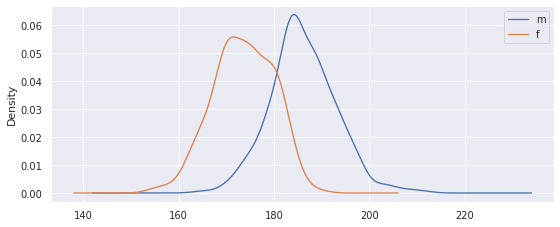

In [26]:
sns.set(rc={'figure.figsize':(10,4)})
sex = ['m', 'f']
for s in sex:
    players.ht[players.sex == s].plot(kind='kde')
plt.legend(sex, loc='best')
plt.show()

And we fill the *null* values with a *normal distribution* generated using the mean and the standard deviation of the two distributions above.

In [27]:
for s in sex:
    dist = players['ht'][players['sex'] == s].value_counts(normalize=True)
    miss = players['ht'][players['sex'] == s].isna()
    p_s = players.loc[players['sex'] == s, 'ht']
    players.loc[(players['sex'] == s) & (miss), 'ht'] = np.random.normal(loc=p_s.mean(), scale=p_s.std(), size=len(p_s[miss])).astype(int)

Plotting again we can see how the distributions have been preserved.

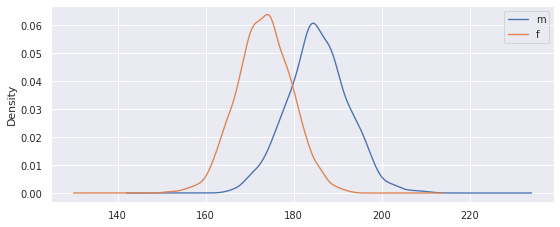

In [28]:
sns.set(rc={'figure.figsize':(10,4)})
sex = ['m', 'f']
for s in sex:
    players.ht[players.sex == s].plot(kind='kde')
plt.legend(sex, loc='best')
plt.show()

Following, we move on the *nationalities* of the players.

In [29]:
players[players['ioc'].isna()]

,hand,ioc,ht,sex,match_count,birthday
fullname,,,,,,
risa ozaki,r,<NA>,181,f,219,1994-04-15
marie bouzkova,<NA>,<NA>,166,f,315,1998-07-25
luksika kumkhum,r,<NA>,181,f,187,1993-07-27
naomi broady,r,<NA>,178,f,211,1990-03-06


Luckily they are only four and we can manage them manually with a web search.

In [30]:
players.loc['risa ozaki', 'ioc'] = 'jpn'
players.loc['marie bouzkova', 'ioc'] = 'cze'
players.loc['luksika kumkhum', 'ioc'] = 'tha'
players.loc['naomi broady', 'ioc'] = 'unk'

Finally, the `hand` of the players.

Again, we want to preserve the original distribution.

<AxesSubplot:>

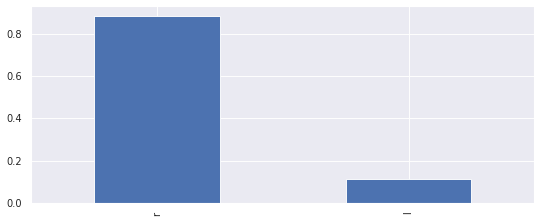

In [31]:
sns.set(rc={'figure.figsize':(10,4)})
players['hand'].value_counts(normalize=True).plot(kind='bar')

In [32]:
hand_dist = players['hand'].value_counts(normalize=True)
miss = players['hand'].isna()
players.loc[miss, 'hand'] = np.random.choice(a=hand_dist.index, size=len(players[miss]), p=hand_dist.values)

<AxesSubplot:>

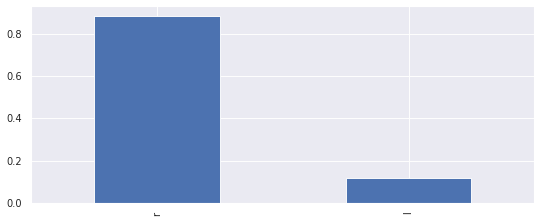

In [33]:
sns.set(rc={'figure.figsize':(10,4)})
players['hand'].value_counts(normalize=True).plot(kind='bar')

And we did.

In [34]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5027 entries, kei nishikori to kai lin zhang
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hand         5027 non-null   string
 1   ioc          5027 non-null   string
 2   ht           5027 non-null   Int64 
 3   sex          5027 non-null   string
 4   match_count  5027 non-null   Int64 
 5   birthday     4538 non-null   object
dtypes: Int64(2), object(1), string(3)
memory usage: 413.8+ KB


In [35]:
tourneys_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4853 entries, 2019-m020 to 2020-w-itf-usa-48a-2020
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_name        4853 non-null   string        
 1   surface             4853 non-null   string        
 2   tourney_date        4853 non-null   datetime64[ns]
 3   tourney_spectators  4853 non-null   Int64         
 4   tourney_revenue     4853 non-null   Float64       
dtypes: Float64(1), Int64(1), datetime64[ns](1), string(2)
memory usage: 237.0+ KB


## Feature Creation

Finally we have all the ingredients needed for the features extraction of the players' dataframe.

The features we have found as interesting and useful for the next tasks are the followings:
* `stats_match_count`: number of matches with available stats of each tennis player
* `ace_mean`, `ace_std`, `df_mean`, `df_std`: mean and standard deviation of number of aces and number of double faults
* `ace_ratio`, `df_ratio`: ratio of aces and double faults out of all services of the player
* `bp_saved_ratio`: ratio of saved breakpoint out of faced ones
* `bp_w_ratio`: ratio of won breakpoints out of fought ones
* `svpt_w_ratio`: ratio of won points out of the ones in which the player served
* `svpt_2nd_w_ratio`: ratio of second-serve won point out of the ones in which the player served and won
* `svpt_1st_fail_ratio`: ratio of points in which the player failed the first serve out of all the points in which the player served
* `w_ratio`: ratio of won matches out of played matches
* `w_ratio_semX`: ratio of won matches out of played matches, in semester $X \in [0, 12]$
* `underdog_w_ratio` and `underdog_match_count`: ratio of won matches as underdog (when the player has a lower rank than its opponent)
* `grass_w_ratio`, `clay_w_ratio`, `hard_w_ratio`, `carpet_w_ratio`: ratio of won matches on each type of tennis court
* `l1_tourney_count`, `l2_tourney_count`: number of Level 1 and Level 2 tournaments in which the player partecipated
* `f_match_count`, `sf_match_count`: number of finals and semifinals match played
* `l1_f_match_count`, `l1_sf_match_count`, `l2_f_match_count`, `l2_sf_match_count`: number of finals and semifinals match played in tournaments of Level 1 and Level 2
* `rank_semX`: mean rank of the player in the semester $X \in [0, 12]$
* `mean_rank`: mean rank of the player along all the semesters
* `rank_points_semX`: mean rank points of the player in the semester $X \in [0, 12]$

### Preparing the Dataset for the extraction

Preliminary to the extraction is the preparation of the dataset. Until now we have kept all the *reasonable* tennis matches in the dataframe, however now we must deal with the features extraction which mainly concerns *stats about the player*, for this reason we are going to drop <u>all the stats about matches ended up with retirement or won by default</u> since they are an incomplete source of information.

In [36]:
len(df[df['score'].str.contains('r') | df['score'].str.contains('w/o')])/len(df) * 100

3.6542167766664155

Those matches represents the $3.65\%$ of the dataset.

In [37]:
p = df[df['score'].str.contains('r') | df['score'].str.contains('w/o')]
df.loc[p.index, stats_columns] = np.nan

Furthermore, we are going to remove all the players that, after this drop, <u>don't have any more match statistics available</u>.

In [38]:
w_stats_columns = list(filter(lambda k: 'w_' in k, df.columns)) + ['winner_rank', 'winner_rank_points']
l_stats_columns = list(filter(lambda k: 'l_' in k, df.columns)) + ['loser_rank', 'loser_rank_points']
display(w_stats_columns)
display(l_stats_columns)

['w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'winner_rank',
 'winner_rank_points']

['l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'loser_rank',
 'loser_rank_points']

In [39]:
w_stats = df[['winner_name'] + w_stats_columns]
w_stats = w_stats.rename(columns={'winner_name' : 'fullname'})
w_stats = w_stats.rename(columns=dict(zip(w_stats_columns, [s.replace('w_', '') for s in w_stats_columns])))

l_stats = df[['loser_name'] + l_stats_columns]
l_stats = l_stats.rename(columns={'loser_name' : 'fullname'})
l_stats = l_stats.rename(columns=dict(zip(l_stats_columns, [s.replace('l_', '') for s in l_stats_columns])))

players_stats = pd.concat([w_stats, l_stats]).dropna(subset=['fullname'])
display(players_stats)

,fullname,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,kei nishikori,3,3,77,44,31,17,13,3,6,9,3590,<NA>,<NA>
1,daniil medvedev,10,1,52,33,28,14,10,0,1,16,1977,<NA>,<NA>
2,kei nishikori,2,2,47,33,26,9,8,2,2,9,3590,<NA>,<NA>
3,jo-wilfried tsonga,12,2,68,43,34,15,11,4,5,239,200,<NA>,<NA>
4,daniil medvedev,12,3,105,68,48,25,16,8,8,16,1977,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186068,eleana yu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1216,6
186069,jessica livianu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,729,35
186070,tara moore,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,454,93
186071,chanelle van nguyen,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,627,51


Removing the players with all *null* stats.

In [40]:
stats_columns = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms',
       'bpSaved', 'bpFaced']
players_stats = players_stats.dropna(subset=stats_columns, how='all')
players = players[players.index.isin(players_stats['fullname'])]

### Extracting the features

Now we can start extracting the features described above.

#### `stats_match_count`: number of matches with available stats of each tennis player

In [41]:
players['stats_match_count'] = players_stats.groupby('fullname').size()

#### `ace_mean`, `ace_std`, `df_mean`, `df_std`: mean and standard deviation of number of aces and number of double faults

If a player
* has no info about ace/double faults, the *mean* and *std* will be *null*
* has one single info about ace/double faults, the *std* will be *null*
* has at least two info about ace/double faults but they are all the same, the *std* will be $0$

In [42]:
tmp = players_stats[['fullname', 'ace', 'df']].groupby('fullname').agg(['mean', 'std'])
tmp.columns = ['_'.join(col) for col in tmp.columns]
tmp = tmp.convert_dtypes()
display(tmp)

,ace_mean,ace_std,df_mean,df_std
fullname,,,,
aaron addison,5.636364,3.443043,4.636364,3.324838
abbie myers,2.857143,2.91139,6.0,4.546061
abhinav sanjeev shanmugam,6.0,4.203173,3.230769,1.235168
abigail spears,4.777778,2.818589,3.222222,2.223611
abigail tere apisah,1.357143,1.499084,4.857143,2.983471
...,...,...,...,...
zizou bergs,4.405405,2.683889,2.040541,1.683434
zoe hives,2.882353,2.891417,3.823529,2.404041
zoe kruger,0.714286,0.95119,4.0,1.825742


In [43]:
players = players.join(tmp)

#### `ace_ratio`, `df_ratio`: Ratio of aces and double faults out of all services of the player

In [44]:
tmp = players_stats[['fullname', 'ace', 'svpt']].groupby('fullname').sum(min_count=1)
tmp['ace_ratio'] = tmp['ace'] / tmp['svpt']
players = players.join(tmp[['ace_ratio']])
display(players['ace_ratio'])

fullname
kei nishikori         0.038567
daniil medvedev        0.10336
jo-wilfried tsonga    0.123616
jeremy chardy         0.103885
alex de minaur        0.046221
                        ...   
risa ozaki            0.012743
marie bouzkova         0.02365
luksika kumkhum       0.020539
naomi broady          0.116732
kai lin zhang         0.013527
Name: ace_ratio, Length: 2471, dtype: Float64

In [45]:
tmp = players_stats[['fullname', 'df', 'svpt']].groupby('fullname').sum(min_count=1)
tmp['df_ratio'] = tmp['df'] / tmp['svpt']
players = players.join(tmp[['df_ratio']])
display(players['df_ratio'])

fullname
kei nishikori         0.027849
daniil medvedev       0.043684
jo-wilfried tsonga    0.032346
jeremy chardy         0.052036
alex de minaur         0.03596
                        ...   
risa ozaki            0.026263
marie bouzkova        0.033213
luksika kumkhum       0.066654
naomi broady          0.064879
kai lin zhang         0.078261
Name: df_ratio, Length: 2471, dtype: Float64

#### `bp_saved_ratio`: Ratio of saved breakpoint out of faced ones

If a player has the sum af all its `bpFaced` equal to $1$, then its `bp_saved_ratio` will be *null*

In [46]:
tmp = players_stats[['fullname', 'bpSaved', 'bpFaced']].groupby('fullname').sum(min_count=1)
tmp['bp_saved_ratio'] = tmp['bpSaved'] / tmp['bpFaced']
tmp.loc[np.isnan(tmp.bp_saved_ratio), 'bp_saved_ratio'] = pd.NA
display(tmp)

,bpSaved,bpFaced,bp_saved_ratio
fullname,,,
aaron addison,52,83,0.626506
abbie myers,30,69,0.434783
abhinav sanjeev shanmugam,58,97,0.597938
abigail spears,40,77,0.519481
abigail tere apisah,78,133,0.586466
...,...,...,...
zizou bergs,286,461,0.62039
zoe hives,98,176,0.556818
zoe kruger,24,63,0.380952


In [47]:
players = players.join(tmp[['bp_saved_ratio']])

#### `bp_w_ratio`: Ratio of won breakpoints out of fought ones

To extract this feature we must take into account the values of `bpSaved` and `bpFaced` <u>of the opponent</u>, since these are intended as *defensive statistics*.

If a player has the sum of all the `bpFaced` *of the opponent* equal to zero, then its `bp_w_ratio` will be *null*.

In [48]:
w_won = df[['winner_name','l_bpSaved', 'l_bpFaced' ]].rename({'winner_name':'fullname', 'l_bpSaved':'bpSaved', 'l_bpFaced': 'bpFaced'}, axis=1)
l_won = df[['loser_name','w_bpSaved', 'w_bpFaced' ]].rename({'loser_name':'fullname', 'w_bpSaved':'bpSaved', 'w_bpFaced': 'bpFaced'}, axis=1)
tmp = pd.concat([l_won, w_won]).groupby('fullname').sum(min_count=1)
tmp['bp_w_ratio'] = (tmp['bpFaced'] - tmp['bpSaved']) / tmp['bpFaced']
tmp.loc[np.isnan(tmp.bp_w_ratio), 'bp_w_ratio'] = pd.NA
display(tmp)

,bpSaved,bpFaced,bp_w_ratio
fullname,,,
aaliya ebrahim,<NA>,<NA>,<NA>
aanu ayegbusi,<NA>,<NA>,<NA>
aaron addison,40,56,0.285714
aayushi tanwar,<NA>,<NA>,<NA>
abbie myers,28,50,0.44
...,...,...,...
zorica spasojevic,<NA>,<NA>,<NA>
zoziya kardava,<NA>,<NA>,<NA>
zsombor piros,387,664,0.417169


In [49]:
players = players.join(tmp[['bp_w_ratio']])

#### `svpt_w_ratio`: Ratio of won points out of the ones in which the player served

If a player has the sum of all its `svpt` equal to $0$, then its `svpt_w_ratio` will be *null*.

In [50]:
tmp = players_stats[['fullname', '1stWon', '2ndWon', 'svpt']].groupby('fullname').sum(min_count=1)
tmp['svpt_w_ratio'] = (tmp['1stWon'] + tmp['2ndWon']) / tmp['svpt']
tmp.loc[np.isnan(tmp['svpt_w_ratio']), 'svpt_w_ratio'] = pd.NA
display(tmp)

,1stWon,2ndWon,svpt,svpt_w_ratio
fullname,,,,
aaron addison,283,172,774,0.587855
abbie myers,187,100,542,0.52952
abhinav sanjeev shanmugam,298,226,877,0.597491
abigail spears,249,89,624,0.541667
abigail tere apisah,358,185,987,0.550152
...,...,...,...,...
zizou bergs,2401,874,5153,0.635552
zoe hives,505,264,1401,0.548894
zoe kruger,116,60,403,0.436725


In [51]:
players = players.join(tmp[['svpt_w_ratio']])

#### `svpt_2nd_w_ratio`: Ratio of second-serve won point out of the ones in which the player served and won

In [52]:
tmp = players_stats[['fullname', '1stWon', '2ndWon']].groupby('fullname').sum(min_count=1)
tmp['svpt_2nd_w_ratio'] = tmp['2ndWon'] / (tmp['1stWon'] + tmp['2ndWon'])
display(tmp)

,1stWon,2ndWon,svpt_2nd_w_ratio
fullname,,,
aaron addison,283,172,0.378022
abbie myers,187,100,0.348432
abhinav sanjeev shanmugam,298,226,0.431298
abigail spears,249,89,0.263314
abigail tere apisah,358,185,0.3407
...,...,...,...
zizou bergs,2401,874,0.26687
zoe hives,505,264,0.343303
zoe kruger,116,60,0.340909


In [53]:
players = players.join(tmp[['svpt_2nd_w_ratio']])

#### `svpt_1st_fail_ratio`: Ratio of points in which the player failed the first serve out of all the points in which the player served

In [54]:
first_f = players_stats[['fullname', 'svpt', '1stIn']].groupby('fullname').sum(min_count=1)
first_f['svpt_1st_fail_ratio'] = (first_f['svpt'] - first_f['1stIn']) / first_f['svpt']
display(first_f)

,svpt,1stIn,svpt_1st_fail_ratio
fullname,,,
aaron addison,774,414,0.465116
abbie myers,542,310,0.428044
abhinav sanjeev shanmugam,877,417,0.524515
abigail spears,624,374,0.400641
abigail tere apisah,987,578,0.414387
...,...,...,...
zizou bergs,5153,3445,0.331457
zoe hives,1401,822,0.413276
zoe kruger,403,204,0.493797


In [55]:
players = players.join(first_f[['svpt_1st_fail_ratio']])

#### `w_ratio`: Ratio of won matches out of played matches

In [56]:
won_matches = df.groupby("winner_name").size()
players["w_ratio"] = won_matches.div(players["match_count"], fill_value=0)
players["w_ratio"] = players["w_ratio"].fillna(0)
players["w_ratio"]  = players["w_ratio"].convert_dtypes()

In [57]:
display(players[["w_ratio"]])

,w_ratio
fullname,
kei nishikori,0.674912
daniil medvedev,0.698953
jo-wilfried tsonga,0.634518
jeremy chardy,0.532143
alex de minaur,0.602941
...,...
risa ozaki,0.479452
marie bouzkova,0.615873
luksika kumkhum,0.641711


#### `w_ratio_semX`: Ratio of won matches out of played matches, in semester X

In [58]:
matches_with_dates = df.merge(tourneys_df['tourney_date'], how='left', left_on='tourney_id', right_index=True)
won_by_semester = matches_with_dates.rename(columns={'winner_name':'fullname'}).groupby(['fullname', pd.Grouper(key='tourney_date', freq='6M', origin="start")]).size().rename('won')
lost_by_semester = matches_with_dates.rename(columns={'loser_name':'fullname'}).groupby(['fullname', pd.Grouper(key='tourney_date', freq='6M', origin="start")]).size().rename('lost')
tmp = pd.concat([won_by_semester, lost_by_semester], axis=1).fillna(0)
tmp = tmp['won'] / (tmp['won'] + tmp['lost'])
tmp = tmp.convert_dtypes().rename('win ratio')
display(tmp)

fullname         tourney_date
aaliya ebrahim   2020-01-31      0.222222
aanu ayegbusi    2019-01-31           0.0
                 2020-01-31           0.6
aaron addison    2016-01-31           0.0
                 2016-07-31      0.666667
                                   ...   
zuzana zlochova  2020-01-31      0.571429
                 2020-07-31      0.428571
                 2021-01-31           0.0
                 2021-07-31      0.166667
                 2022-01-31           0.0
Name: win ratio, Length: 31339, dtype: Float64

e.g.: win ratio time series of Kei Nishikori

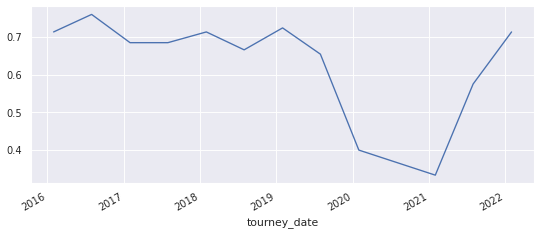

In [59]:
tmp.xs('kei nishikori', level='fullname').plot()
pass

In [60]:
i = 0
for semesterStart in tmp.index.get_level_values(1).unique().sort_values():
    players['w_ratio_sem' + str(i)] = tmp.xs(semesterStart, level='tourney_date')
    i = i+1

In [61]:
display(players[filter(lambda k: 'w_ratio_sem' in k, players.columns)])

,w_ratio_sem0,w_ratio_sem1,w_ratio_sem2,w_ratio_sem3,w_ratio_sem4,w_ratio_sem5,w_ratio_sem6,w_ratio_sem7,w_ratio_sem8,w_ratio_sem9,w_ratio_sem10,w_ratio_sem11,w_ratio_sem12
fullname,,,,,,,,,,,,,
kei nishikori,0.714286,0.76087,0.685714,0.685714,0.714286,0.666667,0.725,0.655172,0.4,<NA>,0.333333,0.575758,0.714286
daniil medvedev,0.6,0.682927,0.75,0.575758,0.5,0.5,0.787234,0.682927,0.8,0.333333,0.769231,0.780488,0.888889
jo-wilfried tsonga,0.714286,0.653846,0.724138,0.730769,0.652174,0.666667,0.416667,0.628571,0.666667,<NA>,<NA>,0.111111,<NA>
jeremy chardy,0.625,0.423077,0.5,0.564103,0.529412,0.630435,0.421053,0.457143,0.64,<NA>,0.444444,0.542857,0.0
alex de minaur,0.0,0.666667,0.722222,0.583333,0.478261,0.66,0.636364,0.5,0.7,0.0,0.695652,0.517241,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
risa ozaki,0.714286,0.592593,0.657143,0.419355,0.2,0.5,0.388889,0.53125,0.25,0.0,<NA>,<NA>,<NA>
marie bouzkova,0.9,0.785714,0.47619,0.690476,0.518519,0.641026,0.62069,0.608696,0.619048,0.666667,0.533333,0.478261,0.2
luksika kumkhum,0.75,0.592593,0.545455,0.7,0.78125,0.645161,0.678571,0.125,0.0,<NA>,<NA>,<NA>,<NA>


#### `underdog_w_ratio` and `underdog_match_count`: Ratio of won matches as underdog (when the player has a lower rank than its opponent)

In [62]:
won_as_underdog  = df[df['winner_rank_points'] < df['loser_rank_points']].groupby('winner_name').size()
lost_as_underdog = df[df['winner_rank_points'] > df['loser_rank_points']].groupby('loser_name').size()
tot_as_underdog = won_as_underdog.add(lost_as_underdog, fill_value=0)
players["underdog_w_ratio"] = won_as_underdog.div(tot_as_underdog, fill_value=0)
players["underdog_w_ratio"] = players["underdog_w_ratio"].convert_dtypes()
players["underdog_match_count"] = tot_as_underdog.convert_dtypes()
players["underdog_match_count"] = players["underdog_match_count"].fillna(0)

In [63]:
display(players[["underdog_w_ratio", "underdog_match_count"]])

,underdog_w_ratio,underdog_match_count
fullname,,
kei nishikori,0.407895,76
daniil medvedev,0.523077,130
jo-wilfried tsonga,0.461538,65
jeremy chardy,0.458333,144
alex de minaur,0.534483,116
...,...,...
risa ozaki,0.3125,80
marie bouzkova,0.371134,97
luksika kumkhum,0.466667,60


#### `grass_w_ratio`, `clay_w_ratio`, `hard_w_ratio`, `carpet_w_ratio`: Ratio of won matches on each type of tennis court

In [64]:
matches_with_surfaces = df.merge(tourneys_df[["surface"]], how='left', left_on='tourney_id', right_index=True)
won_on_surface  = matches_with_surfaces.rename(columns={'winner_name' : 'fullname'}).groupby(["fullname", "surface"]).size().rename('won')
lost_on_surface = matches_with_surfaces.rename(columns={'loser_name' : 'fullname'}).groupby(["fullname", "surface"]).size().rename('lost')
tmp = pd.concat([won_on_surface, lost_on_surface], axis=1).fillna(0)
display(tmp)

won  lost
fullname        surface            
aaliya ebrahim  clay      1.0   4.0
                hard      1.0   3.0
aanu ayegbusi   hard      3.0   3.0
aaron addison   hard      2.0   9.0
aayushi tanwar  hard      1.0   5.0
...                       ...   ...
zsombor piros   hard     16.0  17.0
zuzana bohatova clay      0.0   6.0
zuzana zlochova clay     12.0  21.0
                grass     0.0   1.0
                hard     81.0  64.0

[11177 rows x 2 columns]

In [65]:
tmp = tmp['won'] / (tmp['won'] + tmp['lost'])

players['hard_w_ratio'] = tmp.xs('hard', level='surface').convert_dtypes()
players['clay_w_ratio'] = tmp.xs('clay', level='surface').convert_dtypes()
players['grass_w_ratio'] = tmp.xs('grass', level='surface').convert_dtypes()
players['carpet_w_ratio'] = tmp.xs('carpet', level='surface').convert_dtypes()

Finally, for our purposes for the following clustering task <u>we prefer to have an indicator about the ability of a player on a certain surface which is independent from his actual rank</u>. For this reason we calculate the ratio on a certain surface as 
$$ \textit{surface\_ratio} - \textit{w\_ratio}$$
in this way the ratio will be positive if the player performs better on that surface or negative elsewhere.

In [66]:
players['hard_w_ratio'] = players['hard_w_ratio'] - players['w_ratio']
players['clay_w_ratio'] = players['clay_w_ratio'] - players['w_ratio']
players['grass_w_ratio'] = players['grass_w_ratio'] - players['w_ratio']
players['carpet_w_ratio'] = players['carpet_w_ratio'] - players['w_ratio']

In [67]:
display(players[['hard_w_ratio', 'clay_w_ratio', 'grass_w_ratio', 'carpet_w_ratio']])

,hard_w_ratio,clay_w_ratio,grass_w_ratio,carpet_w_ratio
fullname,,,,
kei nishikori,0.005321,-0.008245,-0.008245,<NA>
daniil medvedev,0.038457,-0.189519,-0.012678,<NA>
jo-wilfried tsonga,0.029716,-0.073542,-0.05557,<NA>
jeremy chardy,0.004002,-0.025814,0.039286,<NA>
alex de minaur,0.029491,-0.212697,0.070972,<NA>
...,...,...,...,...
risa ozaki,0.023373,-0.119452,-0.094837,0.020548
marie bouzkova,0.035387,-0.115873,-0.094134,<NA>
luksika kumkhum,0.043137,-0.641711,-0.204211,<NA>


In [68]:
len(players[players['carpet_w_ratio'].isna()])/len(players) * 100

82.63860785107244

Since more than the $82\%$ of the dataset has no information available about matches *on carpet*, we drop this feature.

In [69]:
players = players.drop(columns='carpet_w_ratio')

#### `l1_tourney_count`, `l2_tourney_count`: Number of Level 1 and Level 2 tournaments in which the player partecipated

We define as *Level 1* the *Grand Slams* and *Masters 1000*s tournaments and as *Level 2* the *ATP Tour* 500 and 250, or equivalents for the *WTA* circuit.

In [70]:
temp_df = tourneys_sex_df.reset_index()
males_tournaments = temp_df[temp_df['sex'] == 'm'].copy()
females_tournaments = temp_df[temp_df['sex'] == 'f'].copy()
females_tournaments = females_tournaments[~females_tournaments['tourney_id'].isin(males_tournaments['tourney_id'])]

In [71]:
males_tournaments = males_tournaments.drop(columns=['draw_size', 'sex'])
females_tournaments = females_tournaments.drop(columns=['draw_size', 'sex'])
tourney_levels = pd.concat([males_tournaments, females_tournaments])

In [72]:
tourney_levels['tourney_level'] = tourney_levels['tourney_level'].replace({'g':'l1', 'm':'l1', 'pm':'l1', 'p':'l2', 'a':'l2'})
match_level = df[df['round'].isin(['f', 'sf', 'qf', 'q1'])].merge(tourney_levels, left_on='tourney_id', right_on='tourney_id')

In [73]:
match_level = match_level[['tourney_id', 'tourney_level', 'winner_name', 'loser_name']]
match_level.head()

,tourney_id,tourney_level,winner_name,loser_name
0,2019-m020,l2,kei nishikori,daniil medvedev
1,2019-m020,l2,daniil medvedev,jo-wilfried tsonga
2,2019-m020,l2,kei nishikori,jeremy chardy
3,2019-m020,l2,jo-wilfried tsonga,alex de minaur
4,2019-m020,l2,daniil medvedev,milos raonic


In [74]:
match_level_winner = match_level[['tourney_id', 'tourney_level', 'winner_name']].copy().rename(columns={'winner_name' : 'fullname'})
match_level_loser = match_level[['tourney_id', 'tourney_level', 'loser_name']].copy().rename(columns={'loser_name' : 'fullname'})
match_level = pd.concat([match_level_winner, match_level_loser]).drop_duplicates()
match_level.head()

,tourney_id,tourney_level,fullname
0,2019-m020,l2,kei nishikori
1,2019-m020,l2,daniil medvedev
3,2019-m020,l2,jo-wilfried tsonga
5,2019-m020,l2,jeremy chardy
8,2019-m020,l2,alex de minaur


In [75]:
match_level = match_level.groupby('fullname')['tourney_level'].value_counts()

In [76]:
for level_name in ['l1', 'l2']:
    players[level_name + '_tourney_count'] = match_level.xs(level_name, level=1)
    players[level_name + '_tourney_count'] = players[level_name + '_tourney_count'].convert_dtypes()
    players[level_name + '_tourney_count'] = players[level_name + '_tourney_count'].fillna(0)
   

In [77]:
players[['l1_tourney_count', 'l2_tourney_count']].head()

,l1_tourney_count,l2_tourney_count
fullname,,
kei nishikori,31,29
daniil medvedev,24,39
jo-wilfried tsonga,12,26
jeremy chardy,12,41
alex de minaur,12,30


#### `f_match_count`, `sf_match_count`: Number of final and semifinals matches played

In [78]:
winners_rounds_count = df.rename(columns={'winner_name':'fullname'}).groupby('fullname')['round'].value_counts()
losers_rounds_count = df.rename(columns={'loser_name':'fullname'}).groupby('fullname')['round'].value_counts()
rounds_count = winners_rounds_count.add(losers_rounds_count, fill_value=0).astype(int)

In [79]:
for round_name in ['f', 'sf']:
    players[round_name + '_match_count'] = rounds_count.xs(round_name, level=1)
    players[round_name + '_match_count'] = players[round_name + '_match_count'].convert_dtypes().fillna(0)
    

#### `l1_f_match_count`, `l1_sf_match_count`, `l2_f_match_count`, `l2_sf_match_count`: Number of final and semifinals matches played in tournaments of Level 1 and Level 2

In [80]:
matches_with_levels = df.merge(tourney_levels, how='left', left_on='tourney_id', right_on='tourney_id')
matches_with_levels['tourney_level'] = matches_with_levels['tourney_level'].replace({'g':'l1', 'm':'l1', 'pm':'l1', 'p':'l2', 'a':'l2'})
matches_with_levels = matches_with_levels[matches_with_levels.tourney_level.isin(['l1', 'l2'])]
matches_with_levels = matches_with_levels[matches_with_levels['round'].isin(['f', 'sf'])]

In [81]:
w_matches_with_levels = matches_with_levels[['winner_name', 'tourney_level', 'round']].rename(columns={'winner_name':'fullname'})
l_matches_with_levels = matches_with_levels[['loser_name', 'tourney_level', 'round']].rename(columns={'loser_name':'fullname'})
matches_with_levels = pd.concat([w_matches_with_levels, l_matches_with_levels])
matches_with_levels = matches_with_levels.groupby(['fullname', 'tourney_level', 'round']).size()
display(matches_with_levels)

fullname             tourney_level  round
adrian mannarino     l2             f         8
                                    sf       13
agnieszka radwanska  l1             sf        2
                     l2             f         3
                                    sf        8
                                             ..
yoshihito nishioka   l2             sf        3
yuichi sugita        l2             f         1
                                    sf        3
yulia putintseva     l2             f         1
                                    sf        2
Length: 714, dtype: int64

In [82]:
for l in ['l1', 'l2']:
    for r in ['f', 'sf']:
        players[l + '_' + r + '_match_count'] = matches_with_levels.xs(l, level='tourney_level').xs(r, level='round')
        players[l + '_' + r + '_match_count'] = players[l + '_' + r + '_match_count'].fillna(0).convert_dtypes()

#### `rank_semX`: Players' mean rank of each semester

In [83]:
matches_with_dates = df.merge(tourneys_df['tourney_date'], how='left', left_on='tourney_id', right_index=True)

In [84]:
ranks = pd.concat([
    matches_with_dates[['winner_name', 'tourney_date', 'winner_rank']].rename(columns={'winner_name':'fullname', 'winner_rank':'rank'}),
    matches_with_dates[['loser_name', 'tourney_date', 'loser_rank']].rename(columns={'loser_name':'fullname', 'loser_rank':'rank'})
]).dropna()

ranks = ranks.groupby(['fullname', pd.Grouper(key='tourney_date', freq='6M', origin="start")]).mean()
display(ranks)

rank
fullname        tourney_date            
aaron addison   2016-01-31        1255.0
                2016-07-31        1254.0
                2017-01-31        1042.0
                2019-01-31        1073.0
                2020-01-31        1045.0
...                                  ...
zuzana zlochova 2020-01-31    355.428571
                2020-07-31    316.142857
                2021-01-31         317.0
                2021-07-31    345.833333
                2022-01-31         375.5

[22593 rows x 1 columns]

e.g.: rank time series of Kei Nishikori

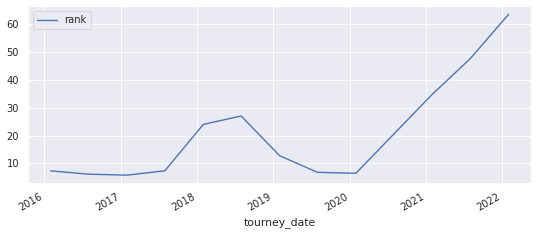

In [85]:
ranks.xs('kei nishikori', level='fullname').plot()
pass

In [86]:
i = 0
for semesterStart in ranks.index.get_level_values(1).unique().sort_values():
    players['rank_sem' + str(i)] = ranks.xs(semesterStart, level='tourney_date').astype(int)
    players['rank_sem' + str(i)] = players['rank_sem' + str(i)].convert_dtypes()
    i = i+1

In [87]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))
display(players[rank_cols])

,rank_sem0,rank_sem1,rank_sem2,rank_sem3,rank_sem4,rank_sem5,rank_sem6,rank_sem7,rank_sem8,rank_sem9,rank_sem10,rank_sem11,rank_sem12
fullname,,,,,,,,,,,,,
kei nishikori,7,6,5,7,24,27,12,6,6,<NA>,34,47,63
daniil medvedev,329,242,128,58,67,55,36,13,5,5,5,2,2
jo-wilfried tsonga,10,9,12,11,15,19,179,112,47,<NA>,<NA>,72,<NA>
jeremy chardy,31,32,69,73,85,81,41,54,66,<NA>,66,59,72
alex de minaur,1586,668,435,239,188,103,34,27,27,25,26,22,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
risa ozaki,147,130,109,81,104,244,295,274,305,315,<NA>,<NA>,<NA>
marie bouzkova,392,295,272,219,175,169,147,117,69,58,48,51,73
luksika kumkhum,159,154,156,194,143,97,90,102,254,<NA>,<NA>,<NA>,<NA>


#### `mean_rank`: Players' mean rank

In [88]:
players['mean_rank'] = players[rank_cols].sum(axis=1) / players[rank_cols].notna().sum(axis=1)

#### `rank_points_semX`: Players' mean rank points of each semester

In [89]:
rank_points = pd.concat([
    matches_with_dates[['winner_name', 'tourney_date', 'winner_rank_points']].rename(columns={'winner_name':'fullname', 'winner_rank_points':'rank_points'}),
    matches_with_dates[['loser_name', 'tourney_date', 'loser_rank_points']].rename(columns={'loser_name':'fullname', 'loser_rank_points':'rank_points'})
]).dropna()

rank_points = rank_points.groupby(['fullname', pd.Grouper(key='tourney_date', freq='6M', origin="start")]).mean()
display(rank_points)

rank_points
fullname        tourney_date             
aaron addison   2016-01-31            6.0
                2016-07-31            6.0
                2017-01-31           10.0
                2019-01-31            9.0
                2020-01-31            8.0
...                                   ...
zuzana zlochova 2020-01-31     136.071429
                2020-07-31          164.0
                2021-01-31          166.0
                2021-07-31          156.0
                2022-01-31          149.5

[22590 rows x 1 columns]

e.g.: rank points time series of Kei Nishikori

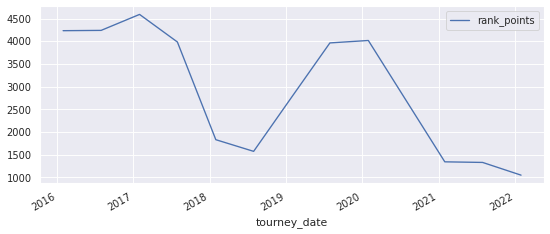

In [90]:
rank_points.xs('kei nishikori', level='fullname').plot()
pass

In [91]:
i = 0
for semesterStart in rank_points.index.get_level_values(1).unique().sort_values():
    players['rank_points_sem' + str(i)] = rank_points.xs(semesterStart, level='tourney_date').astype(int)
    players['rank_points_sem' + str(i)] = players['rank_points_sem' + str(i)].convert_dtypes()
    i = i+1

In [92]:
display(players[filter(lambda k: 'rank_points_sem' in k, players.columns)])

,rank_points_sem0,rank_points_sem1,rank_points_sem2,rank_points_sem3,rank_points_sem4,rank_points_sem5,rank_points_sem6,rank_points_sem7,rank_points_sem8,rank_points_sem9,rank_points_sem10,rank_points_sem11,rank_points_sem12
fullname,,,,,,,,,,,,,
kei nishikori,4235,4241,4593,3986,1832,1575,2783,3965,4019,<NA>,1345,1331,1051
daniil medvedev,144,219,480,810,774,934,1390,2390,4574,5890,6115,9620,10077
jo-wilfried tsonga,2686,3029,2581,2944,2440,2050,380,568,1105,<NA>,<NA>,969,<NA>
jeremy chardy,1255,1229,749,697,625,715,1069,948,858,<NA>,868,1081,994
alex de minaur,2,38,102,219,287,576,1224,1393,1484,1575,1693,2281,2591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
risa ozaki,375,447,584,743,601,226,161,186,176,165,<NA>,<NA>,<NA>
marie bouzkova,91,144,167,238,326,342,413,535,886,981,1247,1450,1069
luksika kumkhum,346,364,366,278,416,668,694,627,231,<NA>,<NA>,<NA>,<NA>


## Feature Analysis

Finally, since we have extracted the interesting features for us, we can perform a *brief* analysis about them.

In [93]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, kei nishikori to kai lin zhang
Data columns (total 72 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hand                  2471 non-null   string 
 1   ioc                   2471 non-null   string 
 2   ht                    2471 non-null   Int64  
 3   sex                   2471 non-null   string 
 4   match_count           2471 non-null   Int64  
 5   birthday              2466 non-null   object 
 6   stats_match_count     2471 non-null   int64  
 7   ace_mean              2471 non-null   Float64
 8   ace_std               2241 non-null   Float64
 9   df_mean               2471 non-null   Float64
 10  df_std                2241 non-null   Float64
 11  ace_ratio             2471 non-null   Float64
 12  df_ratio              2471 non-null   Float64
 13  bp_saved_ratio        2469 non-null   Float64
 14  bp_w_ratio            2453 non-null   Float64
 15  svpt_

In [94]:
feature_columns = ['ace_mean', 'ace_std', 'df_mean', 'df_std', 'ace_ratio', 'df_ratio',
                   'bp_saved_ratio', 'bp_w_ratio', 'svpt_w_ratio',
                   'svpt_2nd_w_ratio', 'svpt_1st_fail_ratio', 'w_ratio', 'underdog_w_ratio',
                   'underdog_match_count', 'hard_w_ratio', 'clay_w_ratio', 'grass_w_ratio',
                   'l1_tourney_count', 'l2_tourney_count', 'f_match_count', 'sf_match_count',
                   'l1_f_match_count', 'l1_sf_match_count', 'l2_f_match_count', 'l2_sf_match_count',
                   'mean_rank']

### Distribution

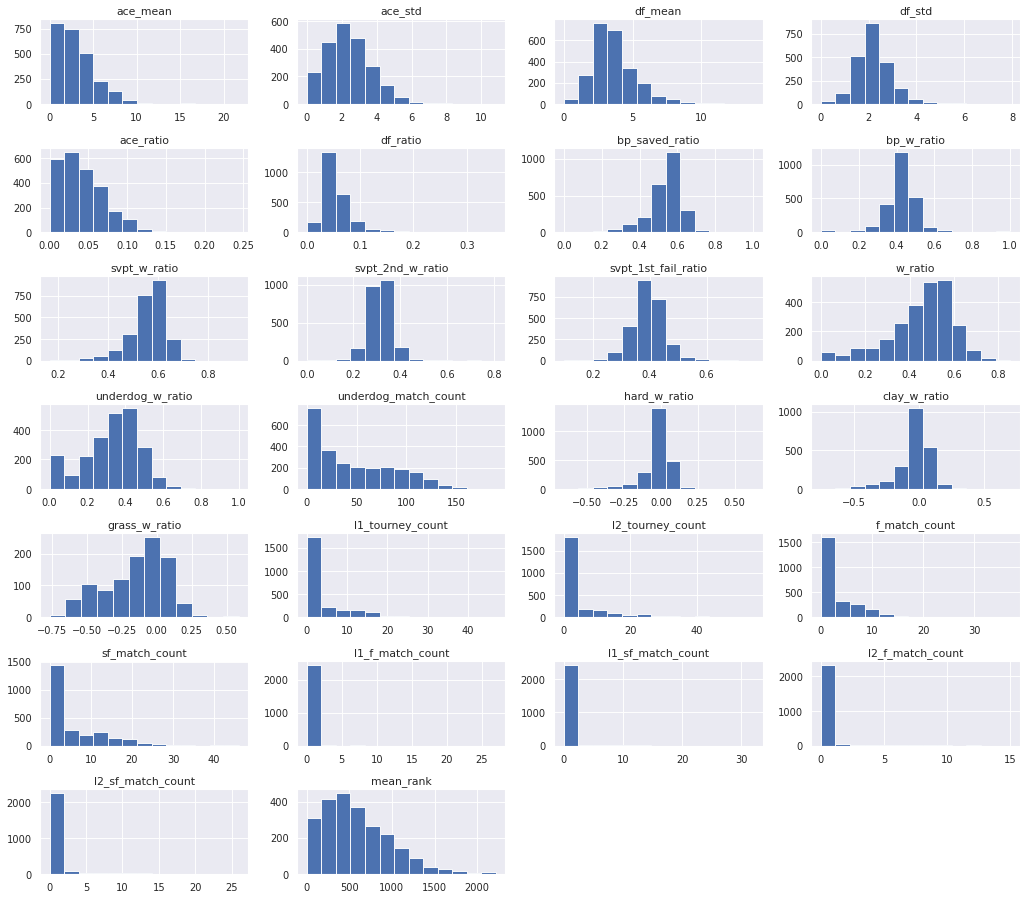

In [103]:
_ = players.hist(column=feature_columns, figsize=(16,14), layout=(7, 4), bins='sturges')
plt.tight_layout()
plt.show()

We can perform the following considerations about the distribution of the features above:
* The dataset contains mostly *"second class"* players, as we can see from all the features, bur particularly from the Level 1 and Level 2 *match count*.
* The *ratio* features behaves in a *normal* distribution way, which is what we would expect.
* A lot of players has no information regarding certain features, probably because of an insufficient number of matches.

### Outliers

In [104]:
ratio_features = [x for x in feature_columns if 'ratio' in x]

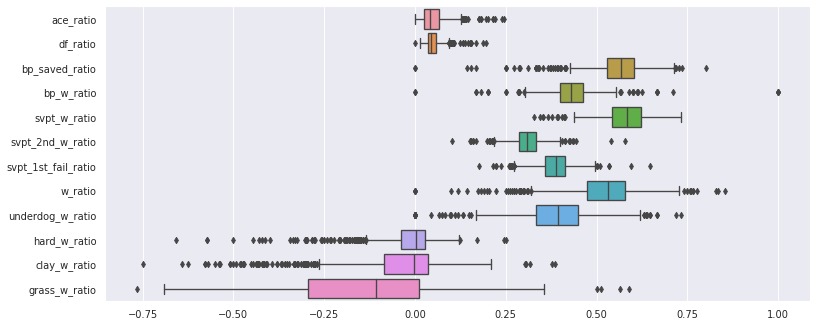

In [106]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=players[ratio_features].dropna(), orient='h')
pass

Likewise, the features face an high number of outliers which, we are convinced (and spoiler: we are right) are due to the *low* number of matches that some player have, creating outliers in the ratio, however we prefer to deal with those player in the next task of clustering, where we are going to look to a <u>*threshold of a minimum number of matches which produces valid clusters*</u>.

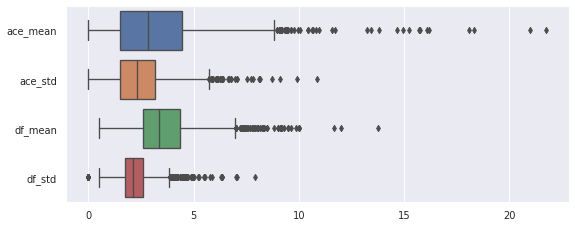

In [111]:
other_features = [x for x in feature_columns if x not in ratio_features and 'count' not in x]
other_features.remove('mean_rank')
sns.boxplot(data=players[other_features].dropna(), orient='h')
pass

### Correlation

In [112]:
corr = players[feature_columns].corr()

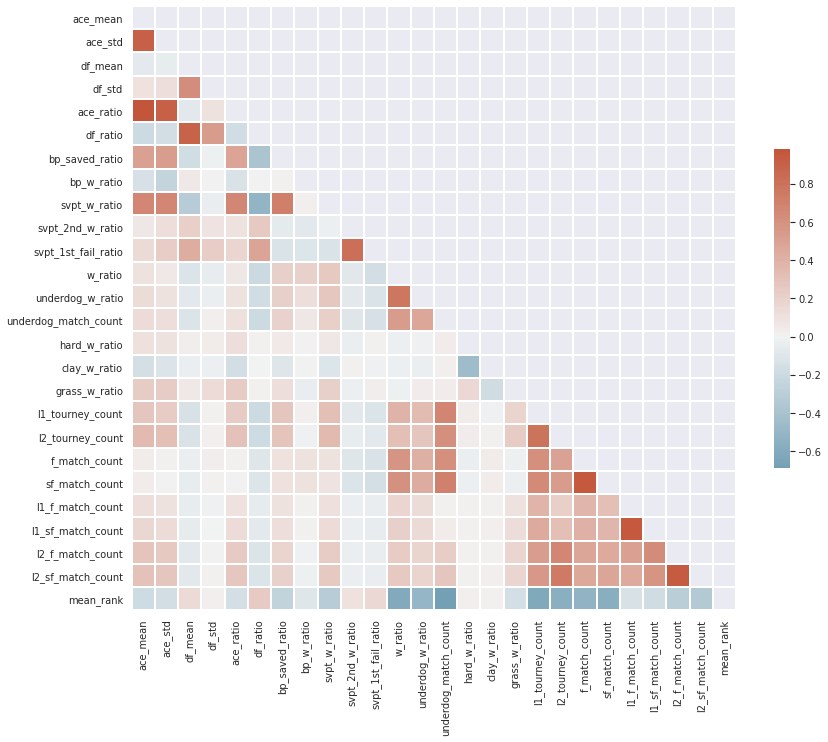

In [113]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Top ten correlations:

In [114]:
corr_sorted = corr.unstack().sort_values(ascending=False)
corr_sorted = corr_sorted[~corr_sorted.index.isin([(x, x) for x in corr.columns])].drop_duplicates() # removing the diagonal
corr_sorted[:10]

ace_mean             ace_ratio            0.983544
l1_sf_match_count    l1_f_match_count     0.953204
sf_match_count       f_match_count        0.951102
l2_f_match_count     l2_sf_match_count    0.944202
ace_std              ace_mean             0.909564
                     ace_ratio            0.905315
df_mean              df_ratio             0.886422
svpt_1st_fail_ratio  svpt_2nd_w_ratio     0.816305
l2_tourney_count     l1_tourney_count     0.790924
underdog_w_ratio     w_ratio              0.772857
dtype: float64

Lowest ten correlations:

In [115]:
corr_sorted[-10:]

bp_saved_ratio    df_ratio               -0.384565
hard_w_ratio      clay_w_ratio           -0.452790
mean_rank         underdog_w_ratio       -0.497514
svpt_w_ratio      df_ratio               -0.518664
mean_rank         f_match_count          -0.527582
l2_tourney_count  mean_rank              -0.558895
mean_rank         sf_match_count         -0.572421
                  w_ratio                -0.601479
                  l1_tourney_count       -0.614439
                  underdog_match_count   -0.685963
dtype: float64

Highly uncorrelated features.

In [116]:
corr_sorted[(corr_sorted > -0.01) & (corr_sorted < 0.01)]

ace_ratio          f_match_count        0.009834
df_ratio           hard_w_ratio         0.009593
bp_w_ratio         l1_sf_match_count    0.008618
df_std             l2_sf_match_count    0.008096
f_match_count      ace_std              0.007918
svpt_2nd_w_ratio   clay_w_ratio         0.005908
l2_tourney_count   clay_w_ratio         0.005371
l2_f_match_count   df_std               0.004659
bp_w_ratio         df_ratio             0.003774
df_std             bp_w_ratio           0.003745
ace_ratio          sf_match_count       0.003036
ace_std            sf_match_count       0.002202
hard_w_ratio       bp_w_ratio           0.001286
bp_w_ratio         clay_w_ratio         0.000041
df_ratio           clay_w_ratio        -0.001878
l1_sf_match_count  df_std              -0.006519
clay_w_ratio       l1_tourney_count    -0.008637
df_std             l1_f_match_count    -0.009557
l2_tourney_count   bp_w_ratio          -0.009971
dtype: float64

---

# ( Exporting dataframes for Task 2 )

In [211]:
players.to_pickle('./dataset/final_players.pkl')
tourneys_sex_df.to_pickle('./dataset/final_tourneys_sex.pkl')
tourneys_df.to_pickle('./dataset/final_tourneys.pkl')
df.to_pickle('./dataset/final_matches.pkl')